In [ ]:
%cd /kaggle/working
!rm -r VPR2023
!git clone https://github.com/cRumy16/VPR2023.git

In [ ]:
!pip3 install -r /kaggle/working/VPR2023/requirements.txt 

In [ ]:
! python /kaggle/working/VPR2023/download_datasets.py

In [10]:
import torch
import numpy as np
import torchvision.models
import pytorch_lightning as pl

import torchvision.transforms as tfm
from pytorch_metric_learning import losses, miners
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from VPR2023 import utils
from PIL import Image
from IPython.display import display
import os
import numpy as np
from glob import glob
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors

In [11]:
def open_image(path):
    return Image.open(path).convert("RGB")
class TestDataset(data.Dataset):
    def __init__(self, dataset_folder, database_folder="database"):
        super().__init__()
        self.dataset_folder = dataset_folder
        self.database_folder = os.path.join(dataset_folder, database_folder)
        self.dataset_name = os.path.basename(dataset_folder)

        if not os.path.exists(self.dataset_folder):
            raise FileNotFoundError(f"Folder {self.dataset_folder} does not exist")
        if not os.path.exists(self.database_folder):
            raise FileNotFoundError(f"Folder {self.database_folder} does not exist")

        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        #### Read paths and UTM coordinates for all images.
        self.database_paths = sorted(glob(os.path.join(self.database_folder, "**", "*.jpg"), recursive=True))
        if len(self.database_paths) == 0:
            raise FileNotFoundError(f"There are no images under {self.database_folder} , you should change this path")

        self.database_utms = np.array \
            ([(path.split("@")[1], path.split("@")[2]) for path in self.database_paths]).astype(float)

        self.images_paths = [p for p in self.database_paths]
        self.database_num = len(self.database_paths)


    def __getitem__(self, index):
        image_path = self.images_paths[index]
        pil_img = open_image(image_path)
        normalized_img = self.base_transform(pil_img)
        return normalized_img, index

    def __len__(self):
        return len(self.images_paths)
    
    def get_positives(self):
        return self.positives_per_query


In [12]:
from torch.utils.data import Dataset
from typing import Tuple
import faiss 
def find_near(database: Dataset, queries_descriptors : np.ndarray, database_descriptors : np.ndarray, query_utms: np.ndarray,
                    num_preds_to_save : int = 0,
                    save_only_wrong_preds : bool = False):

    # Use a kNN to find predictions
    faiss_index = faiss.IndexFlatL2(queries_descriptors.shape[1])
    faiss_index.add(database_descriptors)
    del database_descriptors

    _, predictions = faiss_index.search(queries_descriptors, 20)
    
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(database.database_utms)
    positives_per_query = knn.radius_neighbors(query_utms,
                                                    radius=25,
                                                    return_distance=False)
    
    save_preds(predictions[:, :num_preds_to_save], database, positives_per_query, save_only_wrong_preds)
    

In [13]:
db_descriptors = []
class LightningModel(pl.LightningModule):
    def __init__(self, test_dataset, descriptors_dim = 512, proxy_bank=None):
        super().__init__()
        self.test_dataset = test_dataset
        
        # Use a pretrained model
        self.model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        # Instantiate the Proxy Head and Proxy Bank
        self.pbank = proxy_bank 
        self.phead = utils.ProxyHead(512)
        self.loss_head = losses.MultiSimilarityLoss(alpha=1, beta=50, base=0.0)
        
        self.mixvpr_out_channels = 256
        self.mixvpr_out_rows = 4
        # MixVPR works with an input of dimension [n_batch, 512, 7,7] == [n_batch, in_channels, in_h, in_w]
        self.model.avgpool = utils.MixVPR( in_channels = self.model.fc.in_features, in_h = 7, in_w = 7, out_channels = self.mixvpr_out_channels , out_rows =  self.mixvpr_out_rows )
        
        # Initialize output dim as the standard one of CNN
        self.aggregator_out_dim = self.model.fc.in_features
        self.aggregator_out_dim  = self.mixvpr_out_channels * self.mixvpr_out_rows
        
        self.model.fc = torch.nn.Linear(self.aggregator_out_dim, descriptors_dim)
        
    def forward(self, images):
        descriptors = self.model(images)
        return descriptors
       

    def configure_optimizers(self):
        optimizers = torch.optim.Adam(self.parameters(), lr=0.0001, eps=1e-08, weight_decay=0)
        #optimizers = torch.optim.SGD(self.parameters(), lr=0.0001, weight_decay=0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizers, step_size = 4, gamma=0.1, verbose=True)
        #return optimizers
        return {
        'optimizer': optimizers,
        'lr_scheduler': scheduler,
        'monitor': 'loss'}
    
    # For validation and test, we iterate step by step over the validation set
    def inference_step(self, batch):
        images, _ = batch
        descriptors= self(images)
        return descriptors.cpu().numpy().astype(np.float32)
    
    def test_step(self, batch, batch_idx):
        return self.inference_step(batch)

    def test_epoch_end(self, all_descriptors):
        return self.inference_epoch_end(all_descriptors, self.test_dataset)

    def inference_epoch_end(self, all_descriptors, inference_dataset):
        if self.pbank is not None:
            self.pbank.update_index()
        """all_descriptors contains database then queries descriptors"""
        all_descriptors = np.concatenate(all_descriptors)
        #print(len(all_descriptors))
        queries_descriptors = all_descriptors[inference_dataset.database_num : ]
        database_descriptors = all_descriptors[ : inference_dataset.database_num]
        global db_descriptors
        db_descriptors = np.copy(database_descriptors)
        
def get_dataset(path):
    test_dataset = TestDataset(dataset_folder=path)
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, num_workers=2, shuffle=False)
    return test_dataset,test_loader

In [14]:
import cv2
import numpy as np
from tqdm import tqdm
from skimage.transform import rescale
from PIL import Image, ImageDraw, ImageFont


# Height and width of a single image
H = 512
W = 512
TEXT_H = 175
FONTSIZE = 80
SPACE = 50  # Space between two images


def write_labels_to_image(labels=["text1", "text2"]):
    """Creates an image with vertical text, spaced along rows."""
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", FONTSIZE)
    img = Image.new('RGB', ((W * len(labels)) + 50 * (len(labels)-1), TEXT_H), (1, 1, 1))
    d = ImageDraw.Draw(img)
    for i, text in enumerate(labels):
        _, _, w, h = d.textbbox((0,0), text, font=font)
        d.text(((W+SPACE)*i + W//2 - w//2, 1), text, fill=(0, 0, 0), font=font)
    return np.array(img)


def draw(img, c=(0, 255, 0), thickness=20):
    """Draw a colored (usually red or green) box around an image."""
    p = np.array([[0, 0], [0, img.shape[0]], [img.shape[1], img.shape[0]], [img.shape[1], 0]])
    for i in range(3):
        cv2.line(img, (p[i, 0], p[i, 1]), (p[i+1, 0], p[i+1, 1]), c, thickness=thickness*2)
    return cv2.line(img, (p[3, 0], p[3, 1]), (p[0, 0], p[0, 1]), c, thickness=thickness*2)


def build_prediction_image(images_paths, preds_correct=None):
    """Build a row of images, where the first is the query and the rest are predictions.
    For each image, if is_correct then draw a green/red box.
    """
    assert len(images_paths) == len(preds_correct)
    labels = ["Query"] + [f"Pr{i} - {is_correct}" for i, is_correct in enumerate(preds_correct[1:])]
    num_images = len(images_paths)
    images = [np.array(Image.open(path)) for path in images_paths]
    for img, correct in zip(images, preds_correct):
        if correct is None:
            continue
        color = (0, 255, 0) if correct else (255, 0, 0)
        draw(img, color)
    concat_image = np.ones([H, (num_images*W)+((num_images-1)*SPACE), 3])
    rescaleds = [rescale(i, [min(H/i.shape[0], W/i.shape[1]), min(H/i.shape[0], W/i.shape[1]), 1]) for i in images]
    for i, image in enumerate(rescaleds):
        pad_width = (W - image.shape[1] + 1) // 2
        pad_height = (H - image.shape[0] + 1) // 2
        image = np.pad(image, [[pad_height, pad_height], [pad_width, pad_width], [0, 0]], constant_values=1)[:H, :W]
        concat_image[: , i*(W+SPACE) : i*(W+SPACE)+W] = image
    labels_image = write_labels_to_image(labels)
    final_image = np.concatenate([labels_image, concat_image])
    final_image = Image.fromarray((final_image*255).astype(np.uint8))
    # final_image = Image.fromarray((concat_image*255).astype(np.uint8))
    return final_image


def save_preds(predictions, eval_ds, positives_per_query, save_only_wrong_preds=False):
    for query_index, preds in enumerate(predictions):
        list_of_images_paths = [query_path]
        # List of None (query), True (correct preds) or False (wrong preds)
        preds_correct = [None]
        for pred_index, pred in enumerate(preds):
            
            pred_path = eval_ds.database_paths[pred]
            list_of_images_paths.append(pred_path)
            is_correct = pred in positives_per_query[query_index]
            preds_correct.append(is_correct)
        
        if save_only_wrong_preds and preds_correct[1]:
            continue
        
        prediction_image = build_prediction_image(list_of_images_paths, preds_correct)
        display(prediction_image)

In [15]:
def show_near(query_path, db_descriptors, test_dataset, img_to_show): 
    query_utms = np.array((query_path.split("@")[1], query_path.split("@")[2])).astype(float).reshape(1,-1)
    image = Image.open(query_path).convert("RGB")
    #display(image)
    img = test_dataset.base_transform(image)
    img = img.unsqueeze(0)
    model.to("cpu")
    query_descriptors = model(img)
    query_descriptors = query_descriptors.cpu().detach().numpy().astype(np.float32)
    find_near(test_dataset, query_descriptors, db_descriptors,query_utms, img_to_show, False)
    

In [ ]:
# Model Checkpoint
%cd /kaggle/working
!gdown --fuzzy https://drive.google.com/file/d/1jz_3BeMbJVxPyCf9dnyyfBcb00If9Yd-/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1MzBf5A7CRoaBckpO7J9ENOuQjSl7XWca/view?usp=drive_link

In [ ]:
checkpoint_path = glob("A*.ckpt")[0]
database_path= "/kaggle/working/data/tokyo_xs/test"

test_dataset, test_loader = get_dataset(database_path)
kwargs = {"test_dataset": test_dataset}
model = LightningModel.load_from_checkpoint(checkpoint_path, **kwargs)
model=model.eval()

In [18]:
db_descriptors = []
model.to("cuda")

for batch in test_loader:
    images, _ = batch
    images = images.to("cuda")
    features = model(images)
    features = features.cpu().detach().numpy().astype(np.float32)
    db_descriptors.append(features)

db_descriptors = np.concatenate(db_descriptors, axis=0)

In [ ]:
#Download query image -> or insert manually 
!gdown --fuzzy https://drive.google.com/file/d/101DWUGZbvd6nLQfKVGAimmo7NYB7Jk0B/view?usp=sharing 
!gdown --fuzzy https://drive.google.com/file/d/1csw4vn4tj5SlqH-rlmKWZQ4g5QahXsMc/view?usp=drive_link
!gdown --fuzzy https://drive.google.com/file/d/142HrfU-D6w7366hCpZtLlP2m2lUHJ4wR/view?usp=drive_link


In [20]:
query_path = glob("*03815*.jpg")[0] 
query_utms = np.array((query_path.split("@")[1], query_path.split("@")[2])).astype(float).reshape(1,-1)

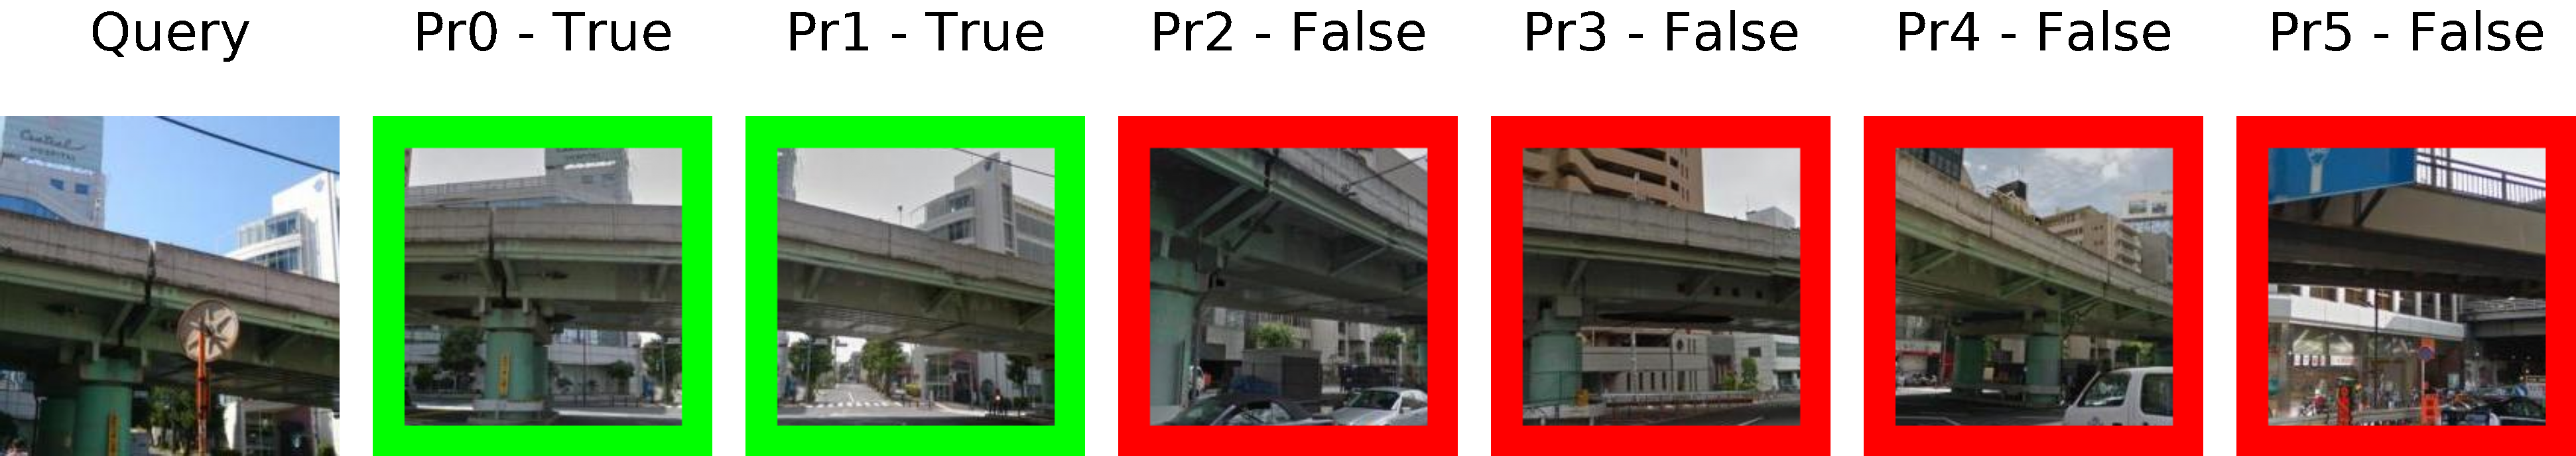

In [21]:
show_near(query_path, db_descriptors, test_dataset,6)